In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import gsw


In [ ]:
ds_weekly_sss = xr.open_dataset('/home/jupyter-daniela/suyana/peru_production/features/OISSS_sss_weekly_2015-2024_4N_74W_16S_83W_0.25deg.nc')
ds_weekly_sst = xr.open_dataset('/home/jupyter-daniela/suyana/peru_production/features/sst_weekly_2015_2024.nc')

In [3]:
class Regridder:
    def __init__(self, method="linear"):
        self.method = method

    def regrid_to_target_grid(self, source_ds, target_ds, source_var=None):
        target_coords = self._get_coords(target_ds)
        source_coords = self._get_coords(source_ds)
        
        target_lats = target_ds[target_coords['lat']].values
        target_lons = target_ds[target_coords['lon']].values
        
        regridded = source_ds.interp(
            **{source_coords['lat']: target_lats,
               source_coords['lon']: target_lons},
            method=self.method
        )
        
        regridded = regridded.rename({
            source_coords['lat']: target_coords['lat'],
            source_coords['lon']: target_coords['lon']
        })
        
        if source_var:
            regridded = regridded[[source_var]]
        
        return regridded
    
    def _get_coords(self, ds):
        lat_names = ['lat', 'latitude', 'LAT', 'LATITUDE']
        lon_names = ['lon', 'longitude', 'LON', 'LONGITUDE']
        
        lat_coord = next((c for c in ds.coords if c in lat_names), None)
        lon_coord = next((c for c in ds.coords if c in lon_names), None)
        
        if not lat_coord or not lon_coord:
            raise ValueError(f"Coordenadas no encontradas. Disponibles: {list(ds.coords.keys())}")
        
        return {'lat': lat_coord, 'lon': lon_coord}

In [ ]:
regridder = Regridder()

sss_ds = xr.open_dataset("/home/jupyter-daniela/suyana/peru_production/features/OISSS_sss_weekly_2015-2024_4N_74W_16S_83W_0.25deg.nc")
sst_ds = xr.open_dataset('/home/jupyter-daniela/suyana/peru_production/features/sst_weekly_2015_2024.nc')

sst_regridded = regridder.regrid_to_target_grid(sst_ds, sss_ds, "sst")

sst_regridded.to_netcdf("/home/jupyter-daniela/suyana/peru_production/features/SST_weekly_2015-2024_4N_74W_16S_83W_0.25deg.nc")

In [ ]:

sss = sss_ds["sss"]
sst = sst_regridded["sst"]

sss_sel = sss.sel(time=slice("2015-01-01", "2024-12-31"))
sst_sel = sst.sel(time=slice("2015-01-01", "2024-12-31"))

sss_sel = sss_sel.sel(time=sss_sel["time"] != np.datetime64("2023-12-31"))
sst_sel = sst_sel.sel(time=sst_sel["time"] != np.datetime64("2024-12-30"))

if sss_sel.sizes["time"] != sst_sel.sizes["time"]:
    raise ValueError(f"Distinta cantidad de tiempos: sss={sss_sel.sizes['time']}, sst={sst_sel.sizes['time']}")

if not np.array_equal(sss_sel["time"].values, sst_sel["time"].values):
    raise ValueError("Los tiempos aún no coinciden después del filtrado")

sss = sss_sel
sst = sst_sel

lon2d, lat2d = xr.broadcast(sss["longitude"], sss["latitude"])
lon2d = lon2d.transpose("latitude", "longitude")
lat2d = lat2d.transpose("latitude", "longitude")

lon3d = np.broadcast_to(lon2d.values[np.newaxis, :, :], sss.shape)
lat3d = np.broadcast_to(lat2d.values[np.newaxis, :, :], sss.shape)


SA = gsw.SA_from_SP(sss.values, 0, lon3d, lat3d)
CT = gsw.CT_from_t(SA, sst.values, 0)
rho = gsw.rho(SA, CT, 0)

rho_da = xr.DataArray(rho, coords=sss.coords, dims=sss.dims, name="rho_surface")

rho_ds = rho_da.to_dataset()

In [52]:
rho_ds.to_netcdf("/home/jupyter-daniela/suyana/peru_production/features/SSD_weekly_2015-2024_4N_74W_16S_83W_0.25deg.nc")


In [57]:

rho_clim = rho_da.groupby("time.week").mean("time")

rho_anom = rho_da.groupby("time.week") - rho_clim

anom_ds = rho_anom.to_dataset(name="rho_surface")
anom_ds.to_netcdf("/home/jupyter-daniela/suyana/peru_production/features/SSD_weekly_anom_2015-2024_4N_74W_16S_83W_0.25deg.nc")

/home/jupyter-daniela/.conda/envs/peru_environment/lib/python3.13/site-packages/xarray/core/dataset_utils.py:86: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  data = getattr(ref_var.dt, var_name).data
/home/jupyter-daniela/.conda/envs/peru_environment/lib/python3.13/site-packages/xarray/core/dataset_utils.py:86: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  data = getattr(ref_var.dt, var_name).data


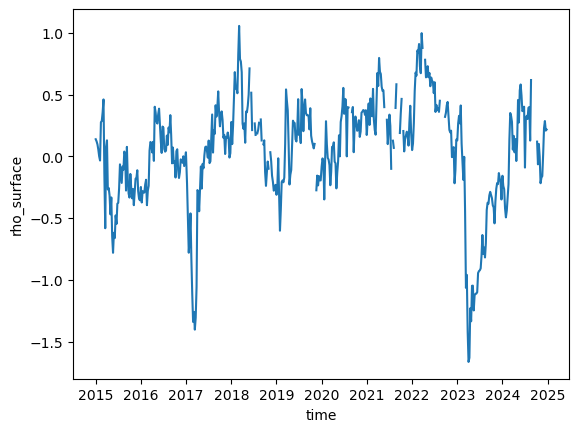

In [61]:
rho_anom.sel(latitude=slice(-10, -8), longitude=slice(-80, -79)).mean(['latitude', 'longitude']).plot()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
from scipy.stats import pearsonr

class OceanPartialCorrelation:
    def __init__(self, sss, sst, rho):
        """
        sss, sst, rho: xarray.DataArray con dims ('time','latitude','longitude')
        """
        self.sss = sss
        self.sst = sst
        self.rho = rho
        self.results = pd.DataFrame()

    def calcular(self, min_registros=21):
        lat = self.sss["latitude"].values
        lon = self.sss["longitude"].values

        resultados = []
        for i, la in enumerate(lat):
            for j, lo in enumerate(lon):
                sss_series = self.sss[:, i, j].values
                sst_series = self.sst[:, i, j].values
                rho_series = self.rho[:, i, j].values

                mask = np.isfinite(sss_series) & np.isfinite(sst_series) & np.isfinite(rho_series)
                if np.count_nonzero(mask) > min_registros:
                    sss_series = sss_series[mask]
                    sst_series = sst_series[mask]
                    rho_series = rho_series[mask]

                    r_rho_sst = pearsonr(rho_series, sst_series)[0]
                    r_rho_sss = pearsonr(rho_series, sss_series)[0]
                    r_sst_sss = pearsonr(sst_series, sss_series)[0]

                    # correlaciones parciales
                    r_partial_rho = (r_rho_sst - r_rho_sss * r_sst_sss) / np.sqrt(
                        (1 - r_rho_sss**2) * (1 - r_sst_sss**2)
                    )
                    r_partial_sst = (r_rho_sss - r_rho_sst * r_sst_sss) / np.sqrt(
                        (1 - r_rho_sst**2) * (1 - r_sst_sss**2)
                    )

                    resultados.append({
                        "lat": la,
                        "lon": lo,
                        "corr_rho_sst": r_rho_sst,
                        "corr_rho_sss": r_rho_sss,
                        "corr_sst_sss": r_sst_sss,
                        "partial_rho": r_partial_rho,
                        "partial_sst": r_partial_sst,
                        "n": len(sss_series)
                    })
        self.results = pd.DataFrame(resultados)

    def visualizar(self, variable="partial_rho", shapefile_path=None):
        if self.results.empty:
            raise ValueError("Primero debes ejecutar calcular()")
        if variable not in ["partial_rho", "partial_sst", "corr_rho_sst", "corr_rho_sss", "corr_sst_sss"]:
            raise ValueError("variable no reconocida")

        grid = self.results.pivot_table(index="lat", columns="lon", values=variable)
        lons = grid.columns.values
        lats = grid.index.values
        Z = grid.values

        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes([0.05, 0.05, 0.85, 0.9])

        if shapefile_path:
            boundary = gpd.read_file(shapefile_path)
            boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)

        levels = np.linspace(-1, 1, 21)
        norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
        mesh = ax.pcolormesh(lons, lats, Z, cmap="RdBu_r", shading="auto", norm=norm)

        cax = plt.axes([0.92, 0.1, 0.02, 0.8])
        plt.colorbar(mesh, cax=cax, ticks=levels, label=f"{variable}")

        ax.set_xlim([min(lons), max(lons)])
        ax.set_ylim([min(lats), max(lats)])
        ax.set_xlabel("Longitud")
        ax.set_ylabel("Latitud")
        ax.set_title(f"Mapa de {variable}", fontsize=10, loc="left")
        plt.show()
